In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
import datetime
import sys
import seaborn as sns
import statsmodels.stats.diagnostic as diag
from statsmodels.tsa.stattools import adfuller
from scipy.stats.mstats import normaltest
from matplotlib.pyplot import acorr
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings

In [2]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [3]:
def check_null(name,df):
    ##check null data
    print("Null values find in {} is {}".format(name,df.isna().sum()))
    
def set_dateIndex(df):
    df.set_index('DATE',inplace=True)
    print("updated dataset\n")
    df.head()

In [4]:
df = pd.read_csv("data_stocks.csv")
df.head()

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,1491226200,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.52,...,84.370,119.035,44.40,39.88,82.03,7.36,50.22,63.86,122.000,53.350
1,1491226260,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.48,...,84.370,119.035,44.11,39.88,82.03,7.38,50.22,63.74,121.770,53.350
2,1491226320,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.93,...,84.585,119.260,44.09,39.98,82.02,7.36,50.12,63.75,121.700,53.365
3,1491226380,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.44,...,84.460,119.260,44.25,39.99,82.02,7.35,50.16,63.88,121.700,53.380
4,1491226440,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.60,...,84.470,119.610,44.11,39.96,82.03,7.36,50.20,63.91,121.695,53.240


Analyzing NASDAQ.AAPL

In [5]:
AAPLdata = df.loc[:,["DATE","NASDAQ.AAPL"]]
AAPLdata.head()

,DATE,NASDAQ.AAPL
0,1491226200,143.6800
1,1491226260,143.7000
2,1491226320,143.6901
3,1491226380,143.6400
4,1491226440,143.6600


In [6]:
#check null
check_null("aapl",AAPLdata)
# set date indec
set_dateIndex(AAPLdata)

Null values find in aapl is DATE           0
NASDAQ.AAPL    0
dtype: int64
updated dataset



In [7]:
AAPLdata.head()

,NASDAQ.AAPL
DATE,
1491226200,143.6800
1491226260,143.7000
1491226320,143.6901
1491226380,143.6400
1491226440,143.6600


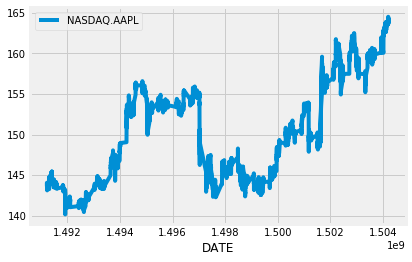

In [8]:
AAPLdata.plot()

In [9]:
adf_check(AAPLdata["NASDAQ.AAPL"])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.9128532997926723
p-value : 0.7837101772613848
#Lags Used : 31
Number of Observations Used : 41234
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
#convert to stationary
AAPLdata["diff1"] = AAPLdata["NASDAQ.AAPL"] -  AAPLdata["NASDAQ.AAPL"].shift(1)
AAPLdata.head()

,NASDAQ.AAPL,diff1
DATE,,
1491226200,143.6800,NaN
1491226260,143.7000,0.0200
1491226320,143.6901,-0.0099
1491226380,143.6400,-0.0501
1491226440,143.6600,0.0200


In [11]:
adf_check(AAPLdata["diff1"].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -35.73774148340111
p-value : 0.0
#Lags Used : 30
Number of Observations Used : 41234
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


Now we have stationary series to apply ARIMA model

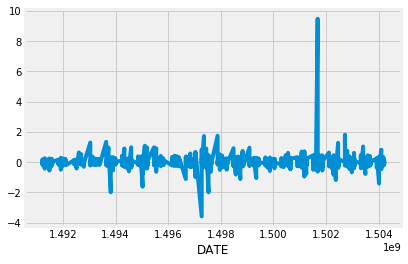

In [12]:
AAPLdata["diff1"].plot()

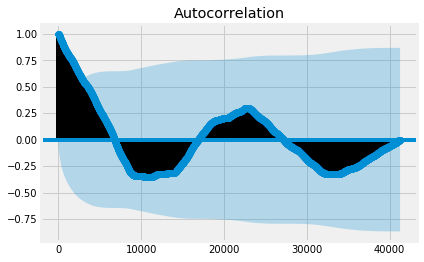

In [13]:
fig_first = plot_acf(AAPLdata["NASDAQ.AAPL"].dropna())

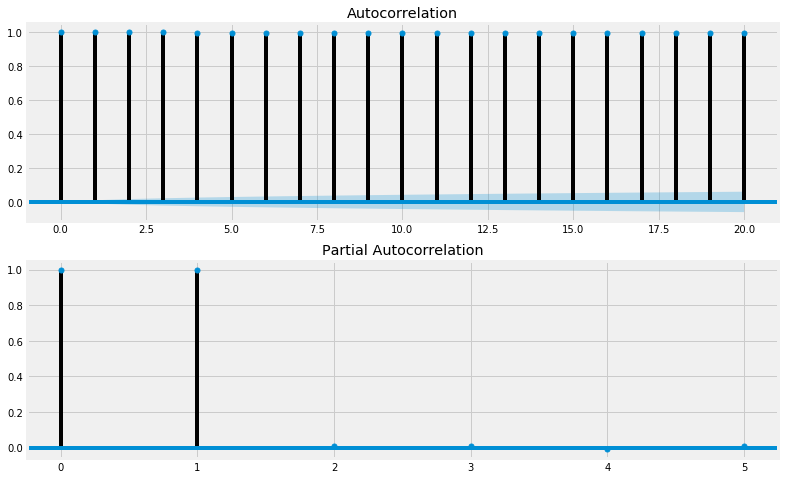

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(AAPLdata['NASDAQ.AAPL'].iloc[1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(AAPLdata['NASDAQ.AAPL'].iloc[1:], lags=5, ax=ax2)

In [15]:
data = np.array(AAPLdata["NASDAQ.AAPL"],'f')
result = None
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    arima = ARIMA(data,[1,1,0])
    result = arima.fit(disp=False)
    
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                41265
Model:                 ARIMA(1, 1, 0)   Log Likelihood               39219.016
Method:                       css-mle   S.D. of innovations              0.094
Date:                Sun, 11 Aug 2019   AIC                         -78432.031
Time:                        08:37:08   BIC                         -78406.148
Sample:                             1   HQIC                        -78423.850
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.079      0.281      -0.000       0.001
ar.L1.D.y     -0.0102      0.005     -2.066      0.039      -0.020      -0.001
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -98.3097           +0.0000j           98.3097            0.5000
-----------------------------------------------------------------------------
"""

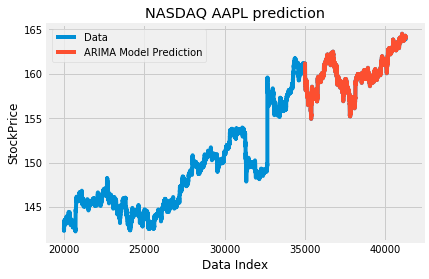

In [16]:
pred = result.predict(35001,typ='levels')
x = [i for i in range(41265)]
plt.plot(x[20000:],data[20001:] ,label='Data')
plt.plot(x[35000:],pred,label='ARIMA Model Prediction')
plt.title("NASDAQ AAPL prediction")
plt.xlabel('Data Index')
plt.ylabel('StockPrice')
plt.legend()
plt.show()

In [17]:
pred= result.predict(1,typ='levels').tolist()
pred = [0] + pred
AAPLdata["forecast"] =pred
AAPLdata.head()

,NASDAQ.AAPL,diff1,forecast
DATE,,,
1491226200,143.6800,NaN,0.000000
1491226260,143.7000,0.0200,143.680485
1491226320,143.6901,-0.0099,143.700290
1491226380,143.6400,-0.0501,143.690692
1491226440,143.6600,0.0200,143.641006


In [18]:
pred= result.predict(1,typ='levels').tolist()
pred = [0] + pred
AAPLdata["forecast"] =pred
AAPLdata.head()

,NASDAQ.AAPL,diff1,forecast
DATE,,,
1491226200,143.6800,NaN,0.000000
1491226260,143.7000,0.0200,143.680485
1491226320,143.6901,-0.0099,143.700290
1491226380,143.6400,-0.0501,143.690692
1491226440,143.6600,0.0200,143.641006


ANALYSE NASDAQ.ADP

In [20]:
ADPdata = df.loc[:,["DATE","NASDAQ.ADP"]]
ADPdata.head()

,DATE,NASDAQ.ADP
0,1491226200,102.2300
1,1491226260,102.1400
2,1491226320,102.2125
3,1491226380,102.1400
4,1491226440,102.0600


In [21]:
#check null
check_null("ADP",ADPdata)
# set date indec
set_dateIndex(ADPdata)

Null values find in ADP is DATE          0
NASDAQ.ADP    0
dtype: int64
updated dataset



In [22]:
ADPdata.head()

,NASDAQ.ADP
DATE,
1491226200,102.2300
1491226260,102.1400
1491226320,102.2125
1491226380,102.1400
1491226440,102.0600


Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.7041735251574448
p-value : 0.4289634442067023
#Lags Used : 39
Number of Observations Used : 41226
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


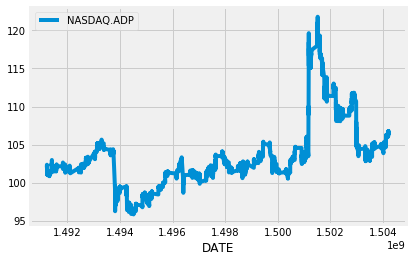

In [23]:
ADPdata.plot()
adf_check(ADPdata["NASDAQ.ADP"])

In [24]:
#convert to stationary
ADPdata["diff1"] = ADPdata["NASDAQ.ADP"] -  ADPdata["NASDAQ.ADP"].shift(1)
ADPdata.head()

,NASDAQ.ADP,diff1
DATE,,
1491226200,102.2300,NaN
1491226260,102.1400,-0.0900
1491226320,102.2125,0.0725
1491226380,102.1400,-0.0725
1491226440,102.0600,-0.0800


In [25]:
adf_check(ADPdata["diff1"].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -31.055662244632302
p-value : 0.0
#Lags Used : 38
Number of Observations Used : 41226
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


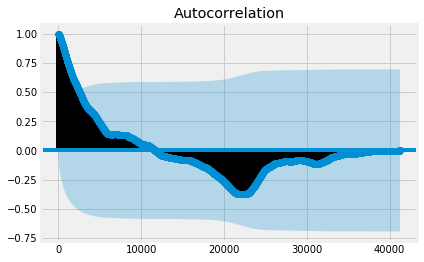

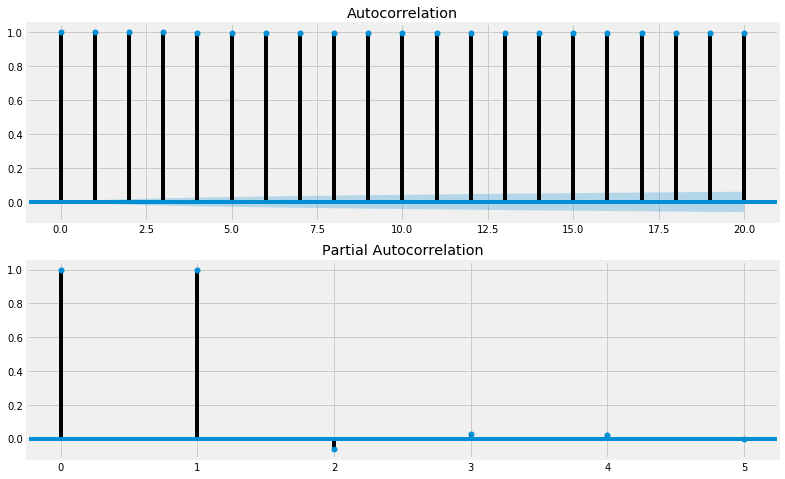

In [26]:
fig_first = plot_acf(ADPdata["NASDAQ.ADP"].dropna())
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ADPdata['NASDAQ.ADP'].iloc[1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ADPdata['NASDAQ.ADP'].iloc[1:], lags=5, ax=ax2)

In [27]:
data = np.array(ADPdata["NASDAQ.ADP"],'f')
result = None
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    arima = ARIMA(data,[1,1,0])
    result = arima.fit(disp=False)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                41265
Model:                 ARIMA(1, 1, 0)   Log Likelihood               48770.649
Method:                       css-mle   S.D. of innovations              0.074
Date:                Sun, 11 Aug 2019   AIC                         -97535.299
Time:                        08:54:07   BIC                         -97509.415
Sample:                             1   HQIC                        -97527.118
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.265      0.791      -0.001       0.001
ar.L1.D.y      0.0570      0.005     11.603      0.000       0.047       0.067
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           17.5357           +0.0000j           17.5357            0.0000
-----------------------------------------------------------------------------
"""

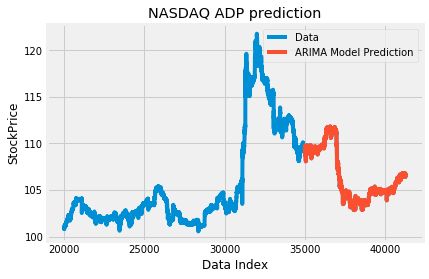

In [28]:
pred = result.predict(35001,typ='levels')
x = [i for i in range(41265)]
plt.plot(x[20000:],data[20001:] ,label='Data')
plt.plot(x[35000:],pred,label='ARIMA Model Prediction')
plt.title("NASDAQ ADP prediction")
plt.xlabel('Data Index')
plt.ylabel('StockPrice')
plt.legend()
plt.show()

In [29]:
pred= result.predict(1,typ='levels').tolist()
pred = [0] + pred
ADPdata["forecast"] =pred
ADPdata.head()

,NASDAQ.ADP,diff1,forecast
DATE,,,
1491226200,102.2300,NaN,0.000000
1491226260,102.1400,-0.0900,102.230106
1491226320,102.2125,0.0725,102.134964
1491226380,102.1400,-0.0725,102.216733
1491226440,102.0600,-0.0800,102.135962


NOW doing for other 3 together

NASDAQ.CBOE

NASDAQ.CSCO

NASDAQ.EBAY

In [30]:
CBOEdata = df.loc[:,["DATE","NASDAQ.CBOE"]]
CSCOdata = df.loc[:,["DATE","NASDAQ.CSCO"]]
EBAYdata = df.loc[:,["DATE","NASDAQ.EBAY"]]

In [31]:
#check null
check_null("cboe",CBOEdata)
check_null("csco",CSCOdata)
check_null("ebay",EBAYdata)
# set date indec
set_dateIndex(CBOEdata)
set_dateIndex(CSCOdata)
set_dateIndex(EBAYdata)

Null values find in cboe is DATE           0
NASDAQ.CBOE    0
dtype: int64
Null values find in csco is DATE           0
NASDAQ.CSCO    0
dtype: int64
Null values find in ebay is DATE           0
NASDAQ.EBAY    0
dtype: int64
updated dataset

updated dataset

updated dataset



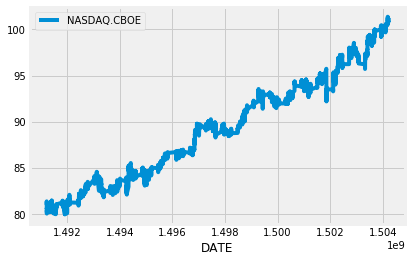

In [32]:
CBOEdata.plot()

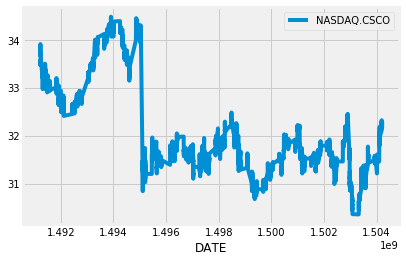

In [33]:
CSCOdata.plot()

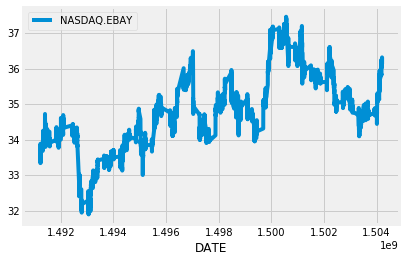

In [34]:
EBAYdata.plot()

In [35]:
adf_check(CBOEdata["NASDAQ.CBOE"])

Augmented Dickey-Fuller Test:
ADF Test Statistic : 0.1663393028261533
p-value : 0.9703092030510077
#Lags Used : 27
Number of Observations Used : 41238
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [36]:
#convert to stationary
CBOEdata["diff1"] = CBOEdata["NASDAQ.CBOE"] -  CBOEdata["NASDAQ.CBOE"].shift(1)
adf_check(CBOEdata["diff1"].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -41.64209364543142
p-value : 0.0
#Lags Used : 26
Number of Observations Used : 41238
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [37]:
adf_check(CSCOdata["NASDAQ.CSCO"])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.395554610889459
p-value : 0.14299501995164532
#Lags Used : 47
Number of Observations Used : 41218
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [38]:
#convert to stationary
CSCOdata["diff1"] = CSCOdata["NASDAQ.CSCO"] -  CSCOdata["NASDAQ.CSCO"].shift(1)
adf_check(CSCOdata["diff1"].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -30.356682532566747
p-value : 0.0
#Lags Used : 46
Number of Observations Used : 41218
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [39]:
adf_check(EBAYdata["NASDAQ.EBAY"])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.875761635941462
p-value : 0.343548087802453
#Lags Used : 47
Number of Observations Used : 41218
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [40]:
#convert to stationary
EBAYdata["diff1"] = EBAYdata["NASDAQ.EBAY"] -  EBAYdata["NASDAQ.EBAY"].shift(1)
adf_check(EBAYdata["diff1"].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -30.679619239193293
p-value : 0.0
#Lags Used : 46
Number of Observations Used : 41218
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [41]:
EBAYdata.head()

,NASDAQ.EBAY,diff1
DATE,,
1491226200,33.3975,NaN
1491226260,33.3950,-0.0025
1491226320,33.4100,0.0150
1491226380,33.3350,-0.0750
1491226440,33.4000,0.0650


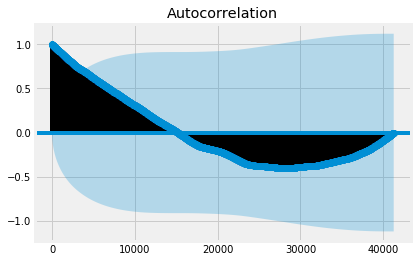

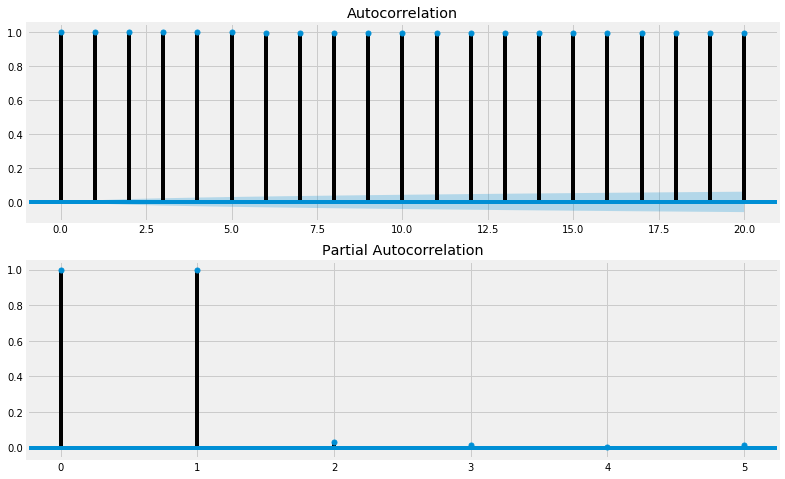

In [42]:
fig_first = plot_acf(CBOEdata["NASDAQ.CBOE"].dropna())
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(CBOEdata['NASDAQ.CBOE'].iloc[1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(CBOEdata['NASDAQ.CBOE'].iloc[1:], lags=5, ax=ax2)

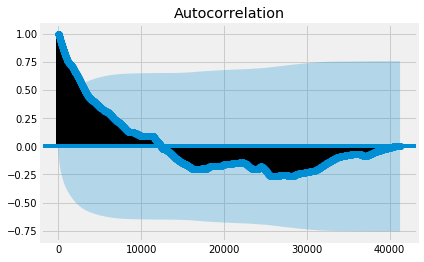

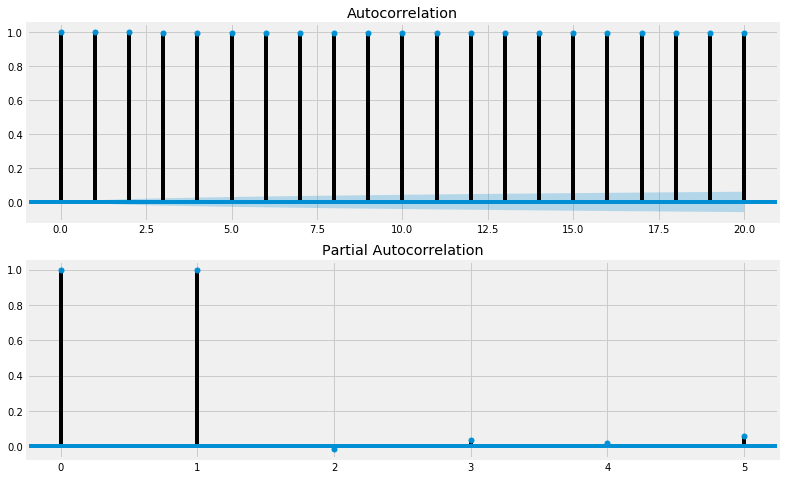

In [43]:
fig_first = plot_acf(CSCOdata["NASDAQ.CSCO"].dropna())
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(CSCOdata['NASDAQ.CSCO'].iloc[1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(CSCOdata['NASDAQ.CSCO'].iloc[1:], lags=5, ax=ax2)

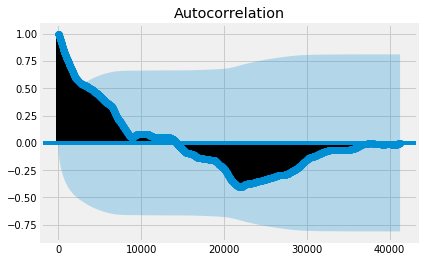

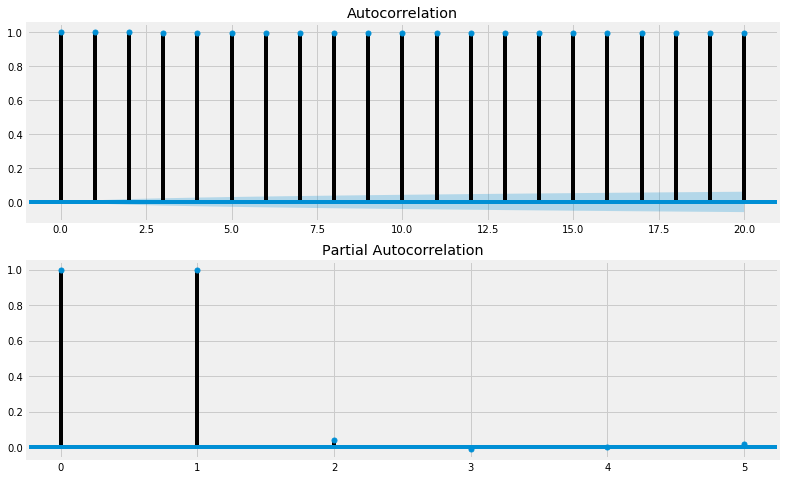

In [44]:
fig_first = plot_acf(EBAYdata["NASDAQ.EBAY"].dropna())
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(EBAYdata['NASDAQ.EBAY'].iloc[1:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(EBAYdata['NASDAQ.EBAY'].iloc[1:], lags=5, ax=ax2)

In [45]:
data = np.array(CBOEdata["NASDAQ.CBOE"],'f')
result = None
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    arima = ARIMA(data,[1,1,0])
    result = arima.fit(disp=False)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                41265
Model:                 ARIMA(1, 1, 0)   Log Likelihood               68084.306
Method:                       css-mle   S.D. of innovations              0.046
Date:                Sun, 11 Aug 2019   AIC                        -136162.612
Time:                        09:05:43   BIC                        -136136.728
Sample:                             1   HQIC                       -136154.431
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.260      0.024    6.39e-05       0.001
ar.L1.D.y     -0.0754      0.005    -15.354      0.000      -0.085      -0.066
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -13.2657           +0.0000j           13.2657            0.5000
-----------------------------------------------------------------------------
"""

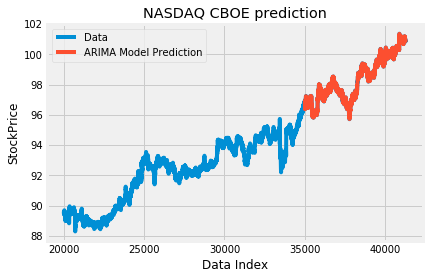

In [46]:
pred = result.predict(35001,typ='levels')
x = [i for i in range(41265)]
plt.plot(x[20000:],data[20001:] ,label='Data')
plt.plot(x[35000:],pred,label='ARIMA Model Prediction')
plt.title("NASDAQ CBOE prediction")
plt.xlabel('Data Index')
plt.ylabel('StockPrice')
plt.legend()
plt.show()

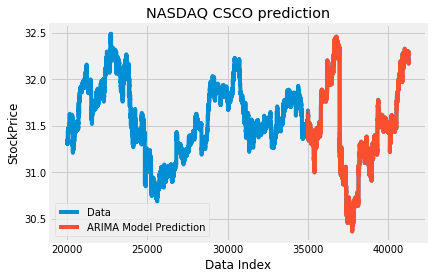

In [47]:
data = np.array(CSCOdata["NASDAQ.CSCO"],'f')
result = None
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    arima = ARIMA(data,[1,1,0])
    result = arima.fit(disp=False)
result.summary()
pred = result.predict(35001,typ='levels')
x = [i for i in range(41265)]
plt.plot(x[20000:],data[20001:] ,label='Data')
plt.plot(x[35000:],pred,label='ARIMA Model Prediction')
plt.title("NASDAQ CSCO prediction")
plt.xlabel('Data Index')
plt.ylabel('StockPrice')
plt.legend()
plt.show()

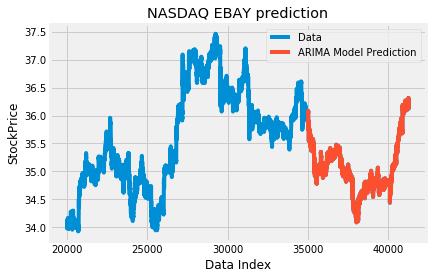

In [48]:
data = np.array(EBAYdata["NASDAQ.EBAY"],'f')
result = None
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    arima = ARIMA(data,[1,1,0])
    result = arima.fit(disp=False)
result.summary()
pred = result.predict(35001,typ='levels')
x = [i for i in range(41265)]
plt.plot(x[20000:],data[20001:] ,label='Data')
plt.plot(x[35000:],pred,label='ARIMA Model Prediction')
plt.title("NASDAQ EBAY prediction")
plt.xlabel('Data Index')
plt.ylabel('StockPrice')
plt.legend()
plt.show()